In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Once the repo is cloned then:
#best practice remove and reeinstal fspec


# instal using the setup.py inside the sam2 repo
#pip install e .
#pip install -e ".[demo]"


# #install also to vizualize figures
# !sudo apt-get update
# !sudo apt-get install -y libgl1-mesa-glx
# !sudo apt-get install -y libglib2.0-0

##Necessary dependencies
#!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
#!pip install fsspec==2024.6.1 --force-reinstall --no-deps
#!pip install shapely
#!pip install s3fs
#!pip install rasterio

## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [7]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Geting the image from Solafune competition uploaded to my s3 bucket

In [8]:
import rasterio
import numpy as np

def load_image_as_array(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
    return image

# Example usage
image_s3_uri = 's3://solafune/train_images/images/train_25.tif'
image = load_image_as_array(image_s3_uri)

# Now 'image' is a NumPy array in RGB format
print(image.shape)  # This will print the shape of the image array


# Assuming 'image' is the array you loaded
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image_normalized = image_normalized.astype(np.uint8)  # Convert to uint8

image = image_normalized

(802, 1198, 3)


In [9]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_l.yaml" #"sam2_hiera_l.yaml" for large

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [10]:
masks = mask_generator.generate(image)

In [11]:
print(len(masks))
print(masks[0].keys())

101
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


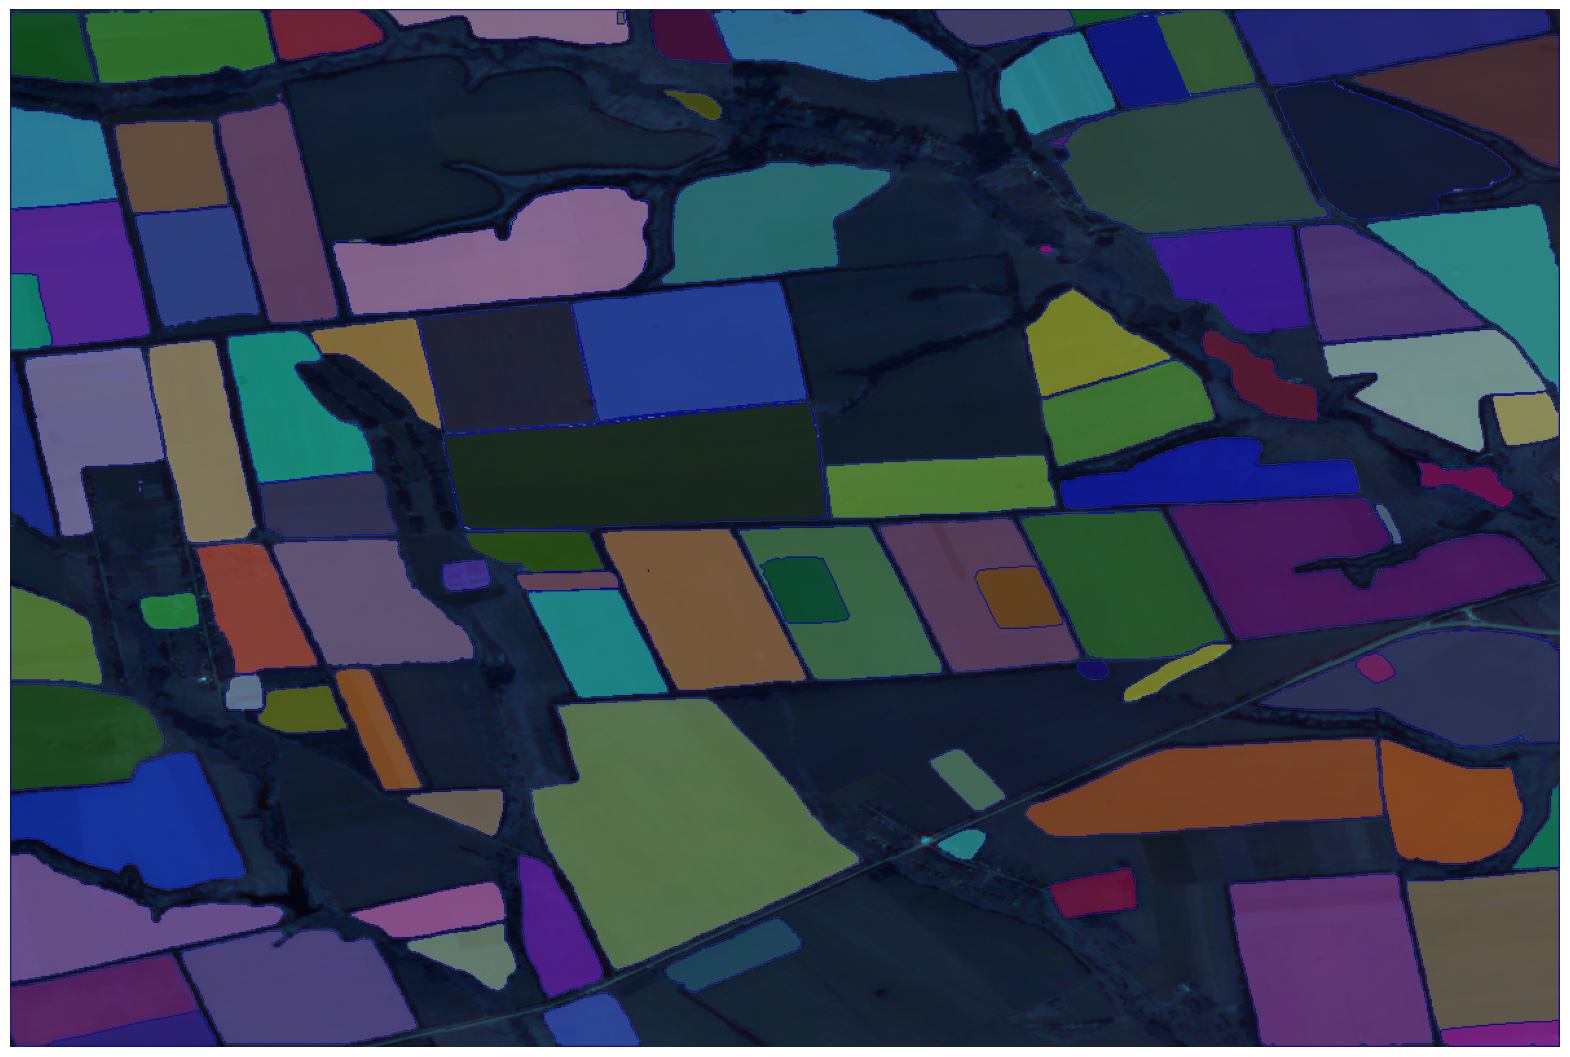

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# Finetuning by retraining the model with solafune's data

In [13]:
import numpy as np
import rasterio
from shapely.geometry import Polygon
from shapely.ops import transform
import cv2
from PIL import Image, ImageDraw

def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return torch.tensor(np.array(mask), dtype=torch.float32)


In [14]:
def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized


def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None
    
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data

In [15]:
import torch
from torch.utils.data import Dataset

class SAM2Dataset(Dataset):
    def __init__(self, image_filenames, annotations, image_s3_prefix):
        self.image_filenames = image_filenames
        self.annotations = annotations
        self.image_s3_prefix = image_s3_prefix

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_s3_uri = os.path.join(self.image_s3_prefix, image_filename)

        # Load image using the new load_image function
        image = load_image(image_s3_uri)
        
        # Ensure the image is in the correct format for the model
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # Set requires_grad=True to enable gradient computation
        #image_tensor.requires_grad_(True)

        # Load annotations
        annotations = load_annotations(self.annotations, image_filename)
        masks = []
        height, width = image.shape[:2]  # Get the image dimensions
        for annotation in annotations:
            mask = polygon_to_mask(annotation['segmentation'], width, height)
            masks.append(mask)

        # Stack all masks into a single tensor
        masks_tensor = torch.stack(masks, dim=0)

        return image_tensor, masks_tensor


In [16]:
# Load Json
import s3fs
import json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'

In [17]:
from torch.utils.data import DataLoader

# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'

# Instantiate Dataset
dataset = SAM2Dataset(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [18]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)


In [19]:
def convert_to_binary_masks(predicted_masks):
    """
    Converts boolean masks from SAM2's output to binary masks.

    Args:
    - predicted_masks (list of dict): List of predicted masks with 'segmentation' key containing boolean arrays.

    Returns:
    - binary_masks (list of np.array): List of binary masks (1 and 0).
    """
    binary_masks = []
    for mask_data in predicted_masks:
        # Convert the boolean segmentation mask to an integer binary mask
        binary_mask = mask_data['segmentation'].astype(np.uint8)
        binary_masks.append(binary_mask)
    
    return binary_masks

Batch 1:
 - Image shape before permute: torch.Size([1, 3, 804, 952])
 - Masks shape: torch.Size([1, 302, 804, 952])
 - Image shape after permute: torch.Size([804, 952, 3])


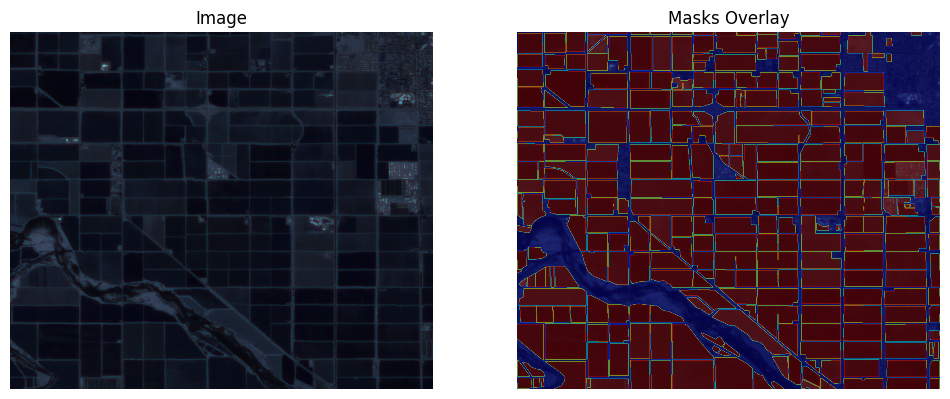

In [20]:
import s3fs
import json

#Looking into the data - Checking if everything is in good order #  image and gt masks


for i, (images, masks) in enumerate(data_loader):
    print(f"Batch {i + 1}:")
    print(f" - Image shape before permute: {images.shape}")
    print(f" - Masks shape: {masks.shape}")
    
    # Assuming images are in the shape [B, C, H, W]
    # Permute to shape [H, W, C] for visualization
    image = images[0].permute(1, 2, 0)
    print(f" - Image shape after permute: {image.shape}")
    
    plt.figure(figsize=(12, 6))
    
    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.detach().numpy())
    plt.title("Image")
    plt.axis('off')
    
    # Show the masks overlayed on the image
    combined_mask = masks[0].sum(axis=0)
    plt.subplot(1, 2, 2)
    plt.imshow(image.detach().numpy())
    plt.imshow(combined_mask, alpha=0.5, cmap='jet')
    plt.title("Masks Overlay")
    plt.axis('off')
    
    plt.show()
    
    # Break after the first batch to inspect
    if i == 0:
        break


# Main train Loop

##### Using a panoptic loss both to better perform on the chalange, and also to compare multiple masks.

In [21]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader


from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_small.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_s.yaml" #"sam2_hiera_l.yaml" for large

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Now instead of all masks let us use image predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# Enable training
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

# Optimizer and mixed precision
optimizer = optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = GradScaler()




In [22]:
import numpy as np
import torch

def generate_random_points(masks_tensor):
    """
    Generate random points within the ground truth masks.

    Args:
    - masks_tensor (torch.Tensor): A tensor of shape (N, H, W) containing N binary masks.

    Returns:
    - points (list): A list of random point coordinates for each mask.
    - labels (list): A list of labels (1 for foreground) corresponding to each point.
    """
    points = []
    labels = []

    for mask in masks_tensor:
        # Find the coordinates of all non-zero points in the mask
        coords = torch.nonzero(mask, as_tuple=False)

        if coords.size(0) > 0:
            # Select a random point from the non-zero coordinates
            random_idx = torch.randint(0, coords.size(0), (1,))
            selected_point = coords[random_idx]

            # Add the selected point (x, y) and the label 1 (foreground)
            points.append([[selected_point[0, 1].item(), selected_point[0, 0].item()]])
            labels.append([1])
        else:
            # If the mask is empty, return a default point (0, 0) and label 0 (background)
            points.append([[0, 0]])
            labels.append([0])

    # Convert points and labels to numpy arrays
    points = np.array(points)
    labels = np.array(labels)

    return points, labels


In [25]:
num_iterations = 10

for itr in range(num_iterations):
    image_tensor, masks_tensor = next(iter(data_loader))  # Load data batch

    # Enforce float32 for all tensors
    image_tensor = image_tensor.cuda().float()  # Ensure the image tensor is in float32
    masks_tensor = masks_tensor.cuda().float()  # Ensure the masks tensor is in float32

    if masks_tensor.shape[0] == 0: 
        continue  # Ignore empty batches

    # Convert to numpy and set image for predictor
    image_tensor_np = image_tensor[0].permute(1, 2, 0).cpu().numpy().astype(np.float32)  # Convert to (H, W, C) and ensure float32
    predictor.set_image(image_tensor_np)

    # Generate random points on masks to simulate input prompts
    input_point, input_label = generate_random_points(masks_tensor)
    
    # Prompt encoding
    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
        input_point, input_label, box=None, mask_logits=None, normalize_coords=True
    )
    
    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
        points=(unnorm_coords, labels),
        boxes=None,
        masks=None,
    )

    # Mask decoder
    batched_mode = unnorm_coords.shape[0] > 1  # Multi-object prediction
    high_res_features = [
        feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]
    ]
    
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=True,
        repeat_image=batched_mode,
        high_res_features=high_res_features,
    )

    # Upscale the masks to the original image resolution
    prd_masks = predictor._transforms.postprocess_masks(
        low_res_masks, predictor._orig_hw[-1]
    )

    # Debug: print out the shapes and dtypes of the tensors
    print(f"gt_mask dtype: {masks_tensor.dtype}, shape: {masks_tensor.shape}")
    print(f"prd_mask dtype: {prd_masks.dtype}, shape: {prd_masks.shape}")
    print(f"prd_scores dtype: {prd_scores.dtype}, shape: {prd_scores.shape}")

    # Segmentation loss calculation
    gt_mask = masks_tensor.float()  # Ensure ground truth mask is float32
    prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map

    # Debug: print intermediate values before loss computation
    print(f"gt_mask: {gt_mask}")
    print(f"prd_mask: {prd_mask}")

    seg_loss = (-gt_mask * torch.log(prd_mask.float() + 1e-7) - (1 - gt_mask) * torch.log((1 - prd_mask.float()) + 1e-7)).mean()


    print(f"seg_loss: {seg_loss}")

    # Score loss calculation (intersection over union) IOU
    inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
    iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
    score_loss = torch.abs(prd_scores[:, 0].float() - iou).mean()


    print(f"score_loss: {score_loss}")
        
    # Ensure all tensors are float32 before loss calculation
    seg_loss = seg_loss.float()
    score_loss = score_loss.float()
    
    # Combine losses
    loss = (seg_loss + score_loss * 0.05).float()  # Force the final loss to be float32
    
    print(f"loss dtype: {loss.dtype}, value: {loss}")
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()  # Without scaler.scale()
    optimizer.step()

    if itr % 1000 == 0: 
        torch.save(predictor.model.state_dict(), "model.torch")
        print("Model saved at iteration", itr)

    # Display results
    if itr == 0: 
        mean_iou = 0
    mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
    print("Iteration:", itr, "Accuracy (IOU):", mean_iou)


gt_mask dtype: torch.float32, shape: torch.Size([1, 464, 803, 995])
prd_mask dtype: torch.float32, shape: torch.Size([1, 3, 803, 995])
prd_scores dtype: torch.bfloat16, shape: torch.Size([1, 3])
gt_mask: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 

RuntimeError: Unexpected floating ScalarType in at::autocast::prioritize

In [29]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [35]:
#test train loop

image_tensor, masks_tensor = next(iter(data_loader))  # Load data batch

# Enforce float32 for all tensors
image_tensor = image_tensor.cuda().float()  # Ensure the image tensor is in float32
masks_tensor = masks_tensor.cuda().float()  # Ensure the masks tensor is in float32


# Convert to numpy and set image for predictor
image_tensor_np = image_tensor[0].permute(1, 2, 0).cpu().numpy().astype(np.float32)  # Convert to (H, W, C) and ensure float32
predictor.set_image(image_tensor_np)

# Generate random points on masks to simulate input prompts
input_point, input_label = generate_random_points(masks_tensor)

# Prompt encoding
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)


sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
    points=(unnorm_coords, labels),
    boxes=None,
    masks=None,
)

# Mask decoder
batched_mode = unnorm_coords.shape[0] > 1  # Multi-object prediction
high_res_features = [
    feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]
]

low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
    image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
    image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=True,
    repeat_image=batched_mode,
    high_res_features=high_res_features,
)

# Upscale the masks to the original image resolution
prd_masks = predictor._transforms.postprocess_masks(
    low_res_masks, predictor._orig_hw[-1]
)

# Debug: print out the shapes and dtypes of the tensors
print(f"gt_mask dtype: {masks_tensor.dtype}, shape: {masks_tensor.shape}")
print(f"prd_mask dtype: {prd_masks.dtype}, shape: {prd_masks.shape}")
print(f"prd_scores dtype: {prd_scores.dtype}, shape: {prd_scores.shape}")

# Segmentation loss calculation
gt_mask = masks_tensor.float()  # Ensure ground truth mask is float32
prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map

# Debug: print intermediate values before loss computation
print(f"gt_mask: {gt_mask}")
print(f"prd_mask: {prd_mask}")

seg_loss = (-gt_mask * torch.log(prd_mask.float() + 1e-7) - (1 - gt_mask) * torch.log((1 - prd_mask.float()) + 1e-7)).mean()






print(f"seg_loss: {seg_loss}")

# Score loss calculation (intersection over union) IOU
inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
score_loss = torch.abs(prd_scores[:, 0].float() - iou).mean()


print(f"score_loss: {score_loss}")

# Combine losses
loss = (seg_loss.float() + score_loss.float() * 0.05).float()  # Ensure the final loss is float32

print(f"loss dtype: {loss.dtype}, value: {loss}")

# Backpropagation
optimizer.zero_grad()
loss.backward()  # Without scaler.scale()
optimizer.step()

if itr % 1000 == 0: 
    torch.save(predictor.model.state_dict(), "model.torch")
    print("Model saved at iteration", itr)

# Display results
if itr == 0: 
    mean_iou = 0
mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
print("Iteration:", itr, "Accuracy (IOU):", mean_iou)

IndexError: index 20 is out of bounds for dimension 0 with size 1

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

class PanopticLoss(nn.Module):
    def __init__(self, iou_threshold=0.5):
        super(PanopticLoss, self).__init__()
        self.iou_threshold = iou_threshold

    def forward(self, predicted_masks, target_masks):
        # Convert to boolean tensors for logical operations
        predicted_masks = predicted_masks > 0.5
        target_masks = target_masks > 0.5

        print(f"Predicted Masks Shape: {predicted_masks.shape}")
        print(f"Target Masks Shape: {target_masks.shape}")

        batch_size = predicted_masks.shape[0]
        total_loss = 0.0

        for i in range(batch_size):
            pred = predicted_masks[i]
            target = target_masks[i]

            print(f"Batch {i + 1}: Pred Shape: {pred.shape}, Target Shape: {target.shape}")

            matched_pred, matched_target = self.match_masks(pred, target)

            print(f"Matched Pred Shape: {matched_pred.shape}, Matched Target Shape: {matched_target.shape}")

            iou_scores = self.calculate_iou(matched_pred, matched_target)

            print(f"IoU Scores: {iou_scores}")

            if iou_scores.numel() > 0:  # Ensure there's something to calculate
                loss = 1 - iou_scores.mean()
                print(f"Loss for Batch {i + 1}: {loss.item()}")
            else:
                loss = torch.tensor(0.0, device=pred.device)
                print("No valid IoU scores, setting loss to 0.")

            total_loss += loss

        final_loss = total_loss / batch_size
        print(f"Final Loss: {final_loss.item()}")

        return final_loss

    def match_masks(self, pred, target):
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)

        print(f"Flattened Pred Shape: {pred.shape}")
        print(f"Flattened Target Shape: {target.shape}")

        matched_pred = []
        matched_target = []

        for i, t in enumerate(target):
            best_iou = 0
            best_pred = None
            for j, p in enumerate(pred):
                intersection = torch.logical_and(p, t).float().sum()
                union = torch.logical_or(p, t).float().sum()
                iou = (intersection + 1e-6) / (union + 1e-6)
                if iou > best_iou:
                    best_iou = iou
                    best_pred = p
            if best_iou > self.iou_threshold:
                matched_pred.append(best_pred)
                matched_target.append(t)

        if matched_pred and matched_target:
            print(f"Number of Matched Pairs: {len(matched_pred)}")
            return torch.stack(matched_pred), torch.stack(matched_target)
        else:
            print("No matches found. Returning zero-filled tensors.")
            return torch.zeros_like(pred), torch.zeros_like(target)

    def calculate_iou(self, pred, target):
        if pred.dim() == 2:
            pred = pred.unsqueeze(0)
        if target.dim() == 2:
            target = target.unsqueeze(0)

        intersection = (pred & target).float().sum((1, 2))
        union = (pred | target).float().sum((1, 2))
        iou = (intersection + 1e-6) / (union + 1e-6)
        return iou


In [ ]:
# import torch

# class SAM2MaskGenerationFunction(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, img_tensor, mask_generator):
#         # Save the original image tensor for backward pass
#         ctx.save_for_backward(img_tensor)
        
#         # Convert the image tensor to a NumPy array for SAM2
#         img_np = img_tensor.permute(1, 2, 0).cpu().numpy()

#         # Generate masks using SAM2 (non-differentiable operation)
#         masks_output = mask_generator.generate(img_np)

#         # Convert masks to binary mask tensor
#         binary_masks_np = np.array(convert_to_binary_masks(masks_output))
#         binary_masks_tensor = torch.tensor(binary_masks_np, dtype=torch.float32).to(img_tensor.device)
        
#         # Reintroduce a differentiable operation
#         #binary_masks_tensor = binary_masks_tensor * img_tensor.sum() * 0 + binary_masks_tensor

#         return binary_masks_tensor

#     @staticmethod
#     def backward(ctx, grad_output):
#         # Retrieve the saved image tensor
#         img_tensor, = ctx.saved_tensors

#         # Here, sum/average the gradients to reduce the dimensions
#         # For simplicity, we assume reducing across the first dimension (e.g., channels or masks)
#         grad_input = grad_output.sum(dim=0, keepdim=True)  # Adjust this based on how you want to reduce

#         # Optionally, expand/reduce dimensions to match input tensor
#         grad_input = grad_input.expand_as(img_tensor)

#         return grad_input, None  # Return gradients for img_tensor and None for mask_generator

# # Example usage remains the same as before.


In [ ]:
# import torch
# import torch.nn as nn

# class SimpleBCELoss(nn.Module):
#     def __init__(self):
#         super(SimpleBCELoss, self).__init__()
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def forward(self, predicted_masks, target_masks):
#         # Check initial grad_fn
#         #print("Initial predicted_masks grad_fn:", predicted_masks.grad_fn)
#         #print("Initial target_masks grad_fn:", target_masks.grad_fn)

#         # Collapse masks by summing across the mask dimension (dim=1)
#         predicted_mask_sum = predicted_masks.sum(dim=1)
#         target_mask_sum = target_masks.sum(dim=1)

#         # Flatten the masks to make them suitable for binary cross-entropy loss
#         predicted_mask_flat = predicted_mask_sum.view(predicted_mask_sum.size(0), -1)
#         target_mask_flat = (target_mask_sum > 0).float().view(target_mask_sum.size(0), -1)

#         # Calculate binary cross-entropy loss with logits
#         loss = self.bce_loss(predicted_mask_flat, target_mask_flat)

#         # Check if loss has a valid grad_fn
#         #print("Loss grad_fn:", loss.grad_fn)

#         return loss


In [ ]:
# def train_model_with_feedback(model, data_loader, mask_generator, num_epochs=5, print_interval=1):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     criterion = SimpleBCELoss()  # Use the binary cross-entropy loss

#     model.train()

#     for epoch in range(num_epochs):
#         epoch_loss = 0
#         for i, (images, masks) in enumerate(tqdm(data_loader, total=len(data_loader))):
#             images, masks = images.to(device), masks.to(device)

#             optimizer.zero_grad()

#             # Generate predicted masks
#             masks_pred = []
#             for img in images:
#                 img = img.permute(1, 2, 0).cpu().numpy()
#                 masks_output = mask_generator.generate(img)
#                 binary_masks = np.array(convert_to_binary_masks(masks_output))
#                 masks_pred.append(torch.tensor(binary_masks, dtype=torch.float32, requires_grad=True).to(device))

#             masks_pred = torch.stack(masks_pred)

#             # Compute the loss
#             loss = criterion(masks_pred, masks)
#             loss.backward()

#             # Check gradients
#             for name, param in model.named_parameters():
#                 print(f"{name} requires_grad: {param.requires_grad}")
#                 if param.grad is not None:
#                     print(f"Gradient for {name}: {param.grad.norm().item()}")
#                 else:
#                     print(f"No gradient for {name}")

#             optimizer.step()
#             epoch_loss += loss.item()

#             # Print loss for every `print_interval` batches
#             if (i + 1) % print_interval == 0:
#                 print(f"Batch [{i + 1}/{len(data_loader)}], Loss: {loss.item():.4f}")

#         print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(data_loader):.4f}")

#     print("Training completed.")


In [ ]:
# # Replace with your actual data loader, model, and mask_generator
# train_model_with_feedback(model, data_loader, mask_generator, num_epochs=1, print_interval=1)

In [ ]:
import torch.nn.functional as F
import torch

def tensor_binary_mask_predictor(model, img_tensor, points_per_side=32, threshold=0.5):
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension if missing
    
    img_tensor = F.interpolate(img_tensor, size=(model.image_size, model.image_size), mode='bilinear', align_corners=False)
    
    # Obtain backbone features
    backbone_features = model.forward_image(img_tensor)
    
    print(f"Backbone features shape before adjustment: {backbone_features['backbone_fpn'][0].shape}")
    
    # Adjust the spatial dimensions
    adjusted_backbone = F.interpolate(
        backbone_features['backbone_fpn'][0],
        size=(model.sam_image_embedding_size, model.sam_image_embedding_size),
        mode='bilinear',
        align_corners=False
    )
    
    # Convert the input tensor to the same dtype as the convolution weights
    conv_layer = torch.nn.Conv2d(in_channels=32, out_channels=model.sam_prompt_embed_dim, kernel_size=1)
    conv_layer = conv_layer.to(adjusted_backbone.dtype)
    
    # Adjust channels to match the expected input channels
    adjusted_backbone = conv_layer(adjusted_backbone)
    
    print(f"Backbone features shape after adjustment: {adjusted_backbone.shape}")
    
    assert adjusted_backbone.size(1) == model.sam_prompt_embed_dim, (
        f"Expected {model.sam_prompt_embed_dim} channels, but got {adjusted_backbone.size(1)}"
    )
    assert adjusted_backbone.size(2) == model.sam_image_embedding_size, (
        f"Expected height {model.sam_image_embedding_size}, but got {adjusted_backbone.size(2)}"
    )
    assert adjusted_backbone.size(3) == model.sam_image_embedding_size, (
        f"Expected width {model.sam_image_embedding_size}, but got {adjusted_backbone.size(3)}"
    )
    
    point_inputs = {
        "point_coords": torch.zeros(1, 1, 2, device=img_tensor.device),
        "point_labels": torch.ones(1, 1, dtype=torch.int32, device=img_tensor.device)
    }
    
    # Generate masks using SAM2's forward method
    with torch.no_grad():
        _, _, _, low_res_masks, high_res_masks, _, _ = model._forward_sam_heads(
            backbone_features=adjusted_backbone,
            point_inputs=point_inputs,
            multimask_output=False
        )
    
    # Apply threshold to get binary masks
    binary_masks = (high_res_masks > threshold).float()
    
    if binary_masks.size(0) == 1:
        binary_masks = binary_masks.squeeze(0)
    
    return binary_masks


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

# Function to display an image
def show_image(tensor, title=""):
    # Denormalize the image if needed
    tensor = tensor.cpu().clone()
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)
    tensor = T.ToPILImage()(tensor)
    plt.imshow(tensor)
    plt.title(title)
    plt.axis('off')

# Function to display a mask
def show_mask(mask, title=""):
    plt.imshow(mask.cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')

# Get a single image from the dataloader
images, _ = next(iter(data_loader))  # Assuming data_loader is your DataLoader
image = images[0].to(device)  # Take the first image and send it to the device

# Generate the binary mask
binary_mask = tensor_binary_mask_predictor(model, image)

# Plot the input image and the generated mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
show_image(image, title="Input Image")

plt.subplot(1, 2, 2)
show_mask(binary_mask, title="Generated Mask")

plt.show()


In [ ]:
def train_model_with_feedback(model, data_loader, num_epochs=5, print_interval=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  # Use the binary cross-entropy loss

    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (images, masks) in enumerate(tqdm(data_loader, total=len(data_loader))):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Generate predicted masks using the tensor_binary_mask_predictor function
            masks_pred = []
            for img in images:
                binary_masks = tensor_binary_mask_predictor(model, img)
                masks_pred.append(binary_masks)

            masks_pred = torch.stack(masks_pred)

            # Compute the loss
            loss = criterion(masks_pred, masks)
            loss.backward()

            optimizer.step()
            epoch_loss += loss.item()

            # Print loss for every `print_interval` batches
            if (i + 1) % print_interval == 0:
                print(f"Batch [{i + 1}/{len(data_loader)}], Loss: {loss.item():.4f}")

        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(data_loader):.4f}")

    print("Training completed.")


In [ ]:
train_model_with_feedback(model, data_loader, num_epochs=2, print_interval=1)

In [ ]:
# Suppose `model` is your model instance
torch.save(model.state_dict(), 'model_weights.pth')


## Test the results

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set the model to evaluation mode if you're done with training


In [ ]:
#testing the new model

image_s3_uri = 's3://solafune/train_images/images/train_0.tif'
image = load_image_as_array(image_s3_uri)
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
image_normalized = image_normalized.astype(np.uint8)  # Convert to uint8
image = image_normalized

#building new generat


new_mask_generator = SAM2AutomaticMaskGenerator(model)

In [ ]:
masks = mask_generator.generate(image)
new_masks = new_mask_generator.generate(image)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(new_masks)
plt.axis('off')
plt.show() 